# 0) Initialization

In [1]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit
import sklearn.linear_model as sklin

import pickle
import sys

In [2]:
fz = 15
lw = 3

In [3]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/'

In [4]:
MSE = xr.open_mfdataset(path+'????/??MSE.nc',combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
dt = 3600
tcoor = dt*np.arange(0,MSE.time.shape[0])

In [6]:
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [7]:
# Calculate Area of domain assuming a rectange (since we assumed constant dx for the contour)
dx = 110/4 #km
A_circle = MSEAtl.shape[1]*MSEAtl.shape[2]*(dx**2)/2 #km**2
A_band = (MSEAtl.shape[2]*dx/np.pi)**2

In [8]:
YEAR = np.linspace(2000,2018,19).astype(int)
print(YEAR)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


# 1) Load quantities of interest

In [216]:
hf = open('PKL_DATA/8_13_IQ.pkl','rb')
IQ_data = pickle.load(hf)

In [217]:
CON_data = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open('PKL_DATA/10_2_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CON_data[year] = tmp['Tot_Contour_km'][str(year)]

In [218]:
# Calculate MMLI from CON_data assuming band or circle shape
MMLI_data = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open('PKL_DATA/10_2_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    MMLI_data[str(year)] = 2*np.sqrt(np.pi*A_circle)/tmp['Tot_Contour_km'][str(year)]

/home/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [219]:
hf = open('PKL_DATA/10_13_LW.pkl','rb')
LW_data = pickle.load(hf)

In [220]:
hf = open('PKL_DATA/10_13_SW.pkl','rb')
SW_data = pickle.load(hf)

In [221]:
hf = open('PKL_DATA/10_14_PRECMEAN.pkl','rb')
PREC_data = pickle.load(hf)

In [222]:
hf = open('PKL_DATA/10_13_WP.pkl','rb')
WP_data = pickle.load(hf)

In [347]:
hf = open('PKL_DATA/10_13_P99.pkl','rb')
P99_data = pickle.load(hf)
hf = open('PKL_DATA/10_13_P999.pkl','rb')
P999_data = pickle.load(hf)
hf = open('PKL_DATA/10_13_P9999.pkl','rb')
P9999_data = pickle.load(hf)

# 2) Scatter them versus degree of aggregation (MMLI/IQ range)

## 2.1) MMLI vs IQ range

In [235]:
MMLI_edges = np.linspace(0.1,0.275,50)
MMLI_binm = PDF.edgTObin(MMLI_edges)
IQ_edges = np.linspace(17,35,50)
IQ_binm = PDF.edgTObin(IQ_edges)

In [236]:
def TwoDhist(Xdata,Ydata,Xedg,Yedg,YEAR,Xnorm=1,Ynorm=1):

    LR = {}

    for i,year in enumerate(YEAR):
        print('i=',i,' & year=',year,' ',end='\r')
        Xarray = Xnorm*np.array(Xdata[str(year)])
        Yarray = Ynorm*np.array(Ydata[str(year)])
        lr = sklin.LinearRegression().fit(Xarray[:,None],Yarray[:,None])
        LR[year] = [lr.intercept_,lr.coef_]
        pdf,tmp,tmp = np.histogram2d(x=Xarray,y=Yarray,bins=(Xedg,Yedg))
        if i==0: HIST2 = pdf
        else: HIST2 += pdf
            
    return HIST2,LR

In [237]:
IQ_MMLI,IQ_MMLI_LR = TwoDhist(MMLI_data,IQ_data['Interquartile_range_MSE'],
                              MMLI_edges,IQ_edges,YEAR[:-1],
                              Xnorm=100,Ynorm=1/2.5e6)

In [238]:
# Create white to blue colormap
Nlev = 20
cmap = cm.get_cmap('Blues', Nlev)
newcolors = cmap(np.linspace(0, 1, Nlev))
white = np.array([1,1,1,1])
newcolors[0,:] = white
cmap = ListedColormap(newcolors)

In [258]:
def PDFplot(binX,binY,PDF,LR,xlab,ylab,YEAR):

    plt.rc('text', usetex=False)
    plt.rc('font', family='serif', size=fz)
    mpl.rcParams['lines.linewidth'] = lw
    plt.close('all')
    plt.figure(figsize=(5,5))

    C = plt.contourf(binX,binY,np.transpose(PDF),cmap=cmap,levels=Nlev)
    cbar = plt.colorbar(C)

    LINE = 0*LR[YEAR[0]][0][0]
    coef_avg = 0; icpt_avg = 0; 
    coef_max = -np.inf; coef_min = np.inf;
    for i,year in enumerate(YEAR):
        LINE += LR[year][0][0]+LR[year][1][0]*binX
        coef_avg += LR[year][1][0]
        icpt_avg += LR[year][0][0]
        if LR[year][1][0]>coef_max:
            icpt_max = LR[year][0][0]
            coef_max = LR[year][1][0]
        if LR[year][1][0]<coef_min:
            icpt_min = LR[year][0][0]
            coef_min = LR[year][1][0]
    LINE = LINE/(i+1); coef_avg = coef_avg/(i+1); icpt_avg = icpt_avg/(i+1);
    LINE_MAX = icpt_max+coef_max*binX
    LINE_MIN = icpt_min+coef_min*binX

    plt.plot(binX,LINE,color=newcolors[-1,:])
    plt.plot(binX,LINE_MIN,linestyle='--',color=newcolors[-1,:])
    plt.plot(binX,LINE_MAX,linestyle='--',color=newcolors[-1,:])
    plt.xlabel(xlab); plt.ylabel(ylab)
    
    plt.text(s='y='+'%02.0f'%coef_avg+'x+'+'%02.0f'%icpt_avg,
             x=binX[-15],y=LINE[-15]-0.1*(LINE.max()-LINE.min()),
             color=newcolors[-1,:])
#     plt.text(s='y='+'%02.0f'%coef_min+'x+'+'%02.0f'%icpt_min,
#              x=binX[-15],y=LINE_MIN[-15]-0.2*(LINE_MIN.max()-LINE_MIN.min()),
#              color=newcolors[-1,:])
#     plt.text(s='y='+'%02.0f'%coef_max+'x+'+'%02.0f'%icpt_max,
#              x=binX[-15],y=LINE_MAX[-15]-0.05*(LINE_MAX.max()-LINE_MAX.min()),
#              color=newcolors[-1,:])

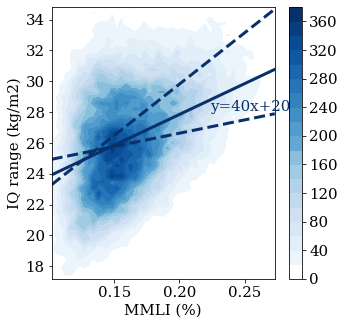

In [259]:
PDFplot(MMLI_binm,IQ_binm,IQ_MMLI,IQ_MML_LR,'MMLI (%)','IQ range (kg/m2)',YEAR[:-1])

## 2.2) Radiation vs MMLI and IQ range

In [260]:
LW_data['LWCOOL']['2009'].max()

225.49829

In [261]:
LW_data['LWCOOL']['2009'].min()

187.87483

In [262]:
LW_edges = np.linspace(185,230,50)
LW_binm = PDF.edgTObin(LW_edges)

In [263]:
LW_MMLI,LW_MMLI_LR = TwoDhist(MMLI_data,LW_data['LWCOOL'],
                              MMLI_edges,LW_edges,YEAR[:-1],
                              Xnorm=100,Ynorm=1)
LW_IQ,LW_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],LW_data['LWCOOL'],
                          IQ_edges,LW_edges,YEAR[:-1],
                          Xnorm=1/2.5e6,Ynorm=1)

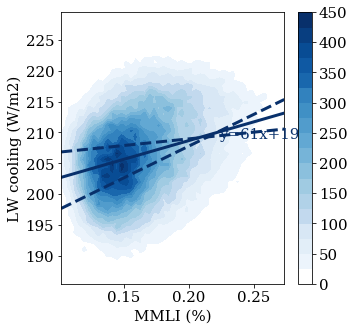

In [271]:
PDFplot(MMLI_binm,LW_binm,LW_MMLI,LW_MMLI_LR,'MMLI (%)','LW cooling (W/m2)',YEAR[:-1])

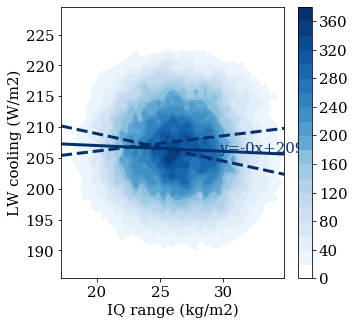

In [266]:
PDFplot(IQ_binm,LW_binm,LW_IQ,LW_IQ_LR,'IQ range (kg/m2)','LW cooling (W/m2)',YEAR[:-1])

In [255]:
SW_data['SWHEAT']['2009'].max()

285.7014

In [256]:
SW_data['SWHEAT']['2009'].min()

-6.9444424e-05

In [267]:
SW_edges = np.linspace(0,290,50)
SW_binm = PDF.edgTObin(SW_edges)

In [268]:
SW_MMLI,SW_MMLI_LR = TwoDhist(MMLI_data,SW_data['SWHEAT'],
                              MMLI_edges,SW_edges,YEAR[:-1],
                              Xnorm=100,Ynorm=1)
SW_IQ,SW_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],SW_data['SWHEAT'],
                          IQ_edges,SW_edges,YEAR[:-1],
                          Xnorm=1/2.5e6,Ynorm=1)

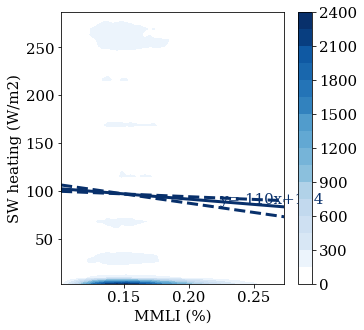

In [270]:
PDFplot(MMLI_binm,SW_binm,SW_MMLI,SW_MMLI_LR,'MMLI (%)','SW heating (W/m2)',YEAR[:-1])

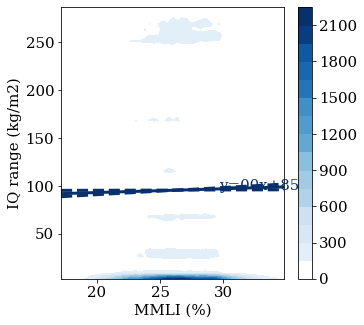

In [272]:
PDFplot(IQ_binm,SW_binm,SW_IQ,SW_IQ_LR,'MMLI (%)','IQ range (kg/m2)',YEAR[:-1])

## 2.3) ITCZ width

In [274]:
WP_data['WP']['2009'].min()

0.44203827

In [279]:
WP_data['WP']['2010'].max()

5.840417

In [292]:
WP_edges = np.linspace(0.25,2,100)
WP_binm = PDF.edgTObin(WP_edges)

In [293]:
WP_MMLI,WP_MMLI_LR = TwoDhist(MMLI_data,WP_data['WP'],
                              MMLI_edges,WP_edges,YEAR[:-1],
                              Xnorm=100,Ynorm=1)
WP_IQ,WP_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],WP_data['WP'],
                          IQ_edges,WP_edges,YEAR[:-1],
                          Xnorm=1/2.5e6,Ynorm=1)

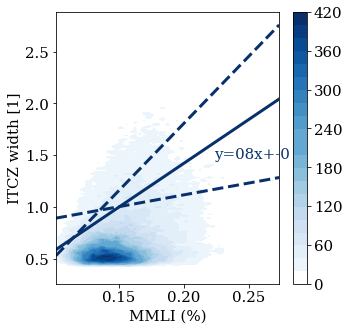

In [294]:
PDFplot(MMLI_binm,WP_binm,WP_MMLI,WP_MMLI_LR,'MMLI (%)','ITCZ width [1]',YEAR[:-1])

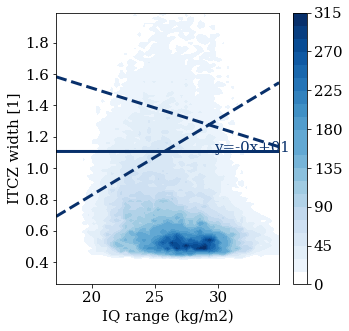

In [295]:
PDFplot(IQ_binm,WP_binm,WP_IQ,WP_IQ_LR,'IQ range (kg/m2)','ITCZ width [1]',YEAR[:-1])

# 2.4) Precipitation extremes

In [348]:
P99_data['P99']['2009'].max()

1956.0

In [298]:
P999_data['P999']['2009'].max()

288.0

In [299]:
P9999_data['P9999']['2009'].max()

63.0

In [352]:
P99_edges = np.linspace(0,1200,120)
P99_binm = PDF.edgTObin(P99_edges)

In [353]:
P99_MMLI,P99_MMLI_LR = TwoDhist(MMLI_data,P99_data['P99'],
                                  MMLI_edges,P99_edges,YEAR[:-1],
                                  Xnorm=100,Ynorm=1)
P99_IQ,P99_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],P99_data['P99'],
                              IQ_edges,P99_edges,YEAR[:-1],
                              Xnorm=1/2.5e6,Ynorm=1)

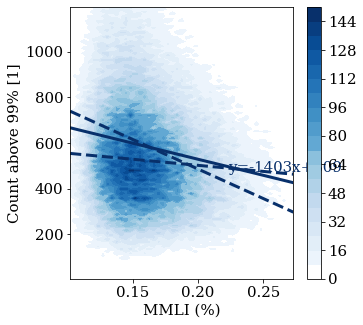

In [354]:
PDFplot(MMLI_binm,P99_binm,P99_MMLI,P99_MMLI_LR,'MMLI (%)','Count above 99% [1]',YEAR[:-1])

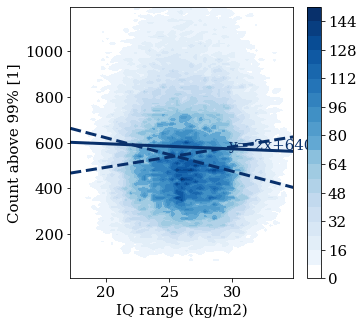

In [355]:
PDFplot(IQ_binm,P99_binm,P99_IQ,P99_IQ_LR,'IQ range (kg/m2)','Count above 99% [1]',YEAR[:-1])

In [330]:
P999_edges = np.linspace(0,125,125)
P999_binm = PDF.edgTObin(P999_edges)

In [331]:
P999_MMLI,P999_MMLI_LR = TwoDhist(MMLI_data,P999_data['P999'],
                                  MMLI_edges,P999_edges,YEAR[:-1],
                                  Xnorm=100,Ynorm=1)
P999_IQ,P999_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],P999_data['P999'],
                              IQ_edges,P999_edges,YEAR[:-1],
                              Xnorm=1/2.5e6,Ynorm=1)

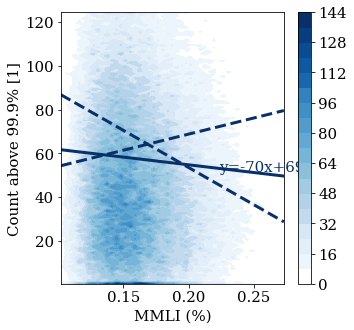

In [332]:
PDFplot(MMLI_binm,P999_binm,P999_MMLI,P999_MMLI_LR,'MMLI (%)','Count above 99.9% [1]',YEAR[:-1])

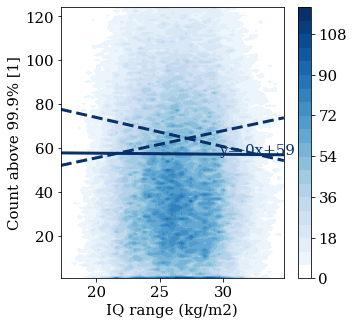

In [333]:
PDFplot(IQ_binm,P999_binm,P999_IQ,P999_IQ_LR,'IQ range (kg/m2)','Count above 99.9% [1]',YEAR[:-1])

In [334]:
P9999_edges = np.linspace(0,12,12)
P9999_binm = PDF.edgTObin(P9999_edges)

In [335]:
P9999_MMLI,P9999_MMLI_LR = TwoDhist(MMLI_data,P9999_data['P9999'],
                                  MMLI_edges,P9999_edges,YEAR[:-1],
                                  Xnorm=100,Ynorm=1)
P9999_IQ,P9999_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],P9999_data['P9999'],
                              IQ_edges,P9999_edges,YEAR[:-1],
                              Xnorm=1/2.5e6,Ynorm=1)

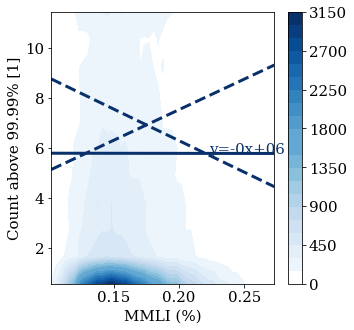

In [336]:
PDFplot(MMLI_binm,P9999_binm,P9999_MMLI,P9999_MMLI_LR,'MMLI (%)','Count above 99.99% [1]',YEAR[:-1])

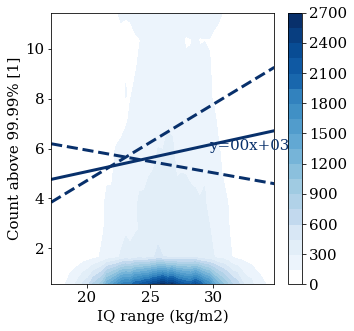

In [337]:
PDFplot(IQ_binm,P9999_binm,P9999_IQ,P9999_IQ_LR,'IQ range (kg/m2)','Count above 99.99% [1]',YEAR[:-1])

## 2.5) Mean precipitation

In [340]:
PREC_data['PRECMEAN']['2009'].max()

0.24403624

In [341]:
PREC_data['PRECMEAN']['2009'].min()

0.050001014

In [342]:
PREC_edges = np.linspace(0,0.25,105)
PREC_binm = PDF.edgTObin(PREC_edges)

In [343]:
PREC_MMLI,PREC_MMLI_LR = TwoDhist(MMLI_data,PREC_data['PRECMEAN'],
                                  MMLI_edges,PREC_edges,YEAR[:-1],
                                  Xnorm=100,Ynorm=1)
PREC_IQ,PREC_IQ_LR = TwoDhist(IQ_data['Interquartile_range_MSE'],PREC_data['PRECMEAN'],
                              IQ_edges,PREC_edges,YEAR[:-1],
                              Xnorm=1/2.5e6,Ynorm=1)

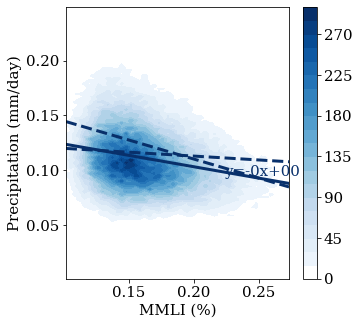

In [344]:
PDFplot(MMLI_binm,PREC_binm,PREC_MMLI,PREC_MMLI_LR,'MMLI (%)','Precipitation (mm/day)',YEAR[:-1])

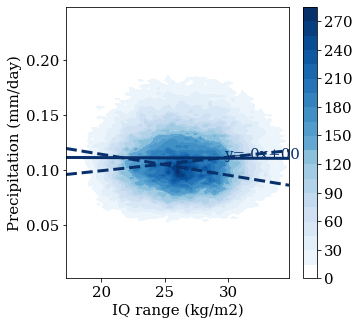

In [345]:
PDFplot(IQ_binm,PREC_binm,PREC_IQ,PREC_IQ_LR,'IQ range (kg/m2)','Precipitation (mm/day)',YEAR[:-1])

# 3) Figure 3